In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import shap

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df_consumo = pd.read_csv('data.csv')
df_consumo

,date,state,stateMessages,volume,logDate,logVolume,deltaVolumes,error,device_name,dev_eui,dev_addr
0,2023-04-03T08:25:45,0,OK,1.221 m3,2023-04-02T17:00:00,1.201 m3,"0.007 m3,0.013 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,...",NaN,5847811,8c83fc0500593b03,015307ae
1,2023-04-03T08:25:22,0,OK,0.832 m3,2023-04-02T17:00:00,0.832 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,6002186,8c83fc05005b960a,01f35e1e
2,2023-04-03T08:26:45,0,OK,0.843 m3,2023-04-02T17:00:00,0.842 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,6002183,8c83fc05005b9607,01cd1fd4
3,2023-04-03T08:26:48,0,OK,2.965 m3,2023-04-02T17:00:00,1.058 m3,"0.797 m3,0.864 m3,0.243 m3,0.0 m3,0.0 m3,0.0 m...",NaN,06154373,8c83fc05005de885,005384e4
4,2023-04-03T08:34:43,0,OK,2.631 m3,2023-04-02T17:00:00,2.618 m3,"0.012 m3,0.001 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,...",NaN,5846673,8c83fc0500593691,00bf9cee
...,...,...,...,...,...,...,...,...,...,...,...
69638,2023-07-18T13:59:06,0,OK,1.223 m3,2023-07-17T22:00:00,1.223 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,6002200,8c83fc05005b9618,0048b15e
69639,2023-07-18T13:59:45,0,OK,6.223 m3,2023-07-17T22:00:00,6.164 m3,"0.003 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.004 m3,...",NaN,6002437,8c83fc05005b9705,00729354
69640,2023-07-18T14:02:26,0,OK,0.799 m3,2023-07-17T23:00:00,0.797 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,6002488,8c83fc05005b9738,00186f5c
69641,2023-07-18T14:06:47,0,OK,55.465 m3,2023-07-17T23:00:00,55.419 m3,"0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 m3,0.0 ...",NaN,5837027,8c83fc05005910e3,01164711


In [3]:
df_consumo_hist = pd.read_excel('Consumo_historico.xlsx')
df_consumo_hist

,Fecha,Valor,Unidad
0,2019-10-31 08:00:00,40,m3
1,2019-11-01 08:00:00,61,m3
2,2019-11-02 08:00:00,74,m3
3,2019-11-03 08:00:00,73,m3
4,2019-11-04 08:00:00,67,m3
...,...,...,...
1319,2023-08-17 08:00:00,172,m3
1320,2023-08-18 08:00:00,155,m3
1321,2023-08-19 08:00:00,127,m3
1322,2023-08-20 08:00:00,136,m3


In [4]:
df_consumo['date'] = pd.to_datetime(df_consumo['date'])
df_consumo = df_consumo[df_consumo['date'].dt.year == 2023]
df_consumo = df_consumo.sort_values(by='date')

In [5]:
df_temp = pd.read_json('temperaturas.json', orient='records')
df_temp

,fecha,indicativo,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha,sol,presMax,horaPresMax,presMin,horaPresMin
0,2023-04-03,3469A,CÁCERES,CACERES,394,"13,0","0,0","4,2",06:00,"21,9",15:00,35,"1,4","6,4",13:35,"11,3","976,0",00,"965,4",23
1,2023-04-04,3469A,CÁCERES,CACERES,394,"16,9","0,0","9,7",06:30,"24,1",15:50,4,"2,5","9,2",11:21,"11,7","970,5",24,"964,8",04
2,2023-04-05,3469A,CÁCERES,CACERES,394,"15,1","0,0","6,4",06:10,"23,8",15:40,2,"2,8","6,7",14:37,"12,3","972,2",10,"968,9",16
3,2023-04-06,3469A,CÁCERES,CACERES,394,"16,4","0,0","6,9",06:20,"25,8",17:00,35,"1,9","6,4",17:00,"12,3","971,5",10,"968,8",Varias
4,2023-04-07,3469A,CÁCERES,CACERES,394,"16,8","0,0","7,1",06:10,"26,6",15:50,18,"1,4","7,5",23:58,"12,4","970,8",10,"967,8",17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2023-07-10,3469A,CÁCERES,CACERES,394,"29,6","0,0","19,0",05:00,"40,1",16:10,28,"1,7","9,7",15:30,"14,2","974,7",08,"970,1",20
99,2023-07-11,3469A,CÁCERES,CACERES,394,"30,0","0,0","22,5",05:30,"37,6",15:30,22,"3,3","11,9",16:20,"14,0","971,6",23,"969,3",17
100,2023-07-12,3469A,CÁCERES,CACERES,394,"26,5","0,0","19,0",05:00,"34,0",15:30,26,"3,1","9,2",17:00,"13,4","973,0",Varias,"970,6",02
101,2023-07-13,3469A,CÁCERES,CACERES,394,"28,4","0,0","20,9",05:10,"35,9",16:30,31,"2,8","8,1",15:15,"14,3","974,1",08,"970,4",19


In [6]:
df_consumo = df_consumo[df_consumo['date'].dt.year == datetime.now().year]
df_consumo = df_consumo.sort_values(by='date')

In [7]:
df_consumo = df_consumo.rename(columns={'volume': 'volumem3'})
df_consumo['volumem3'] = df_consumo['volumem3'].str.replace(' m3', '').astype(float)
df_consumo = df_consumo.rename(columns={'logVolume': 'logVolumem3'})
df_consumo['logVolumem3'] = df_consumo['logVolumem3'].str.replace(' m3', '').astype(float)

In [8]:
def clean_delta_volume(x):
    if isinstance(x, list):
        return [str(item).strip() for item in x]
    elif isinstance(x, str):
        return x.split(',')
    else:
        return [str(x)]

# Aplica la función 'clean_delta_volume' a cada elemento de la columna 'deltaVolumes'
df_consumo['deltaVolumes'] = df_consumo['deltaVolumes'].apply(clean_delta_volume)

# Calcula la longitud máxima de las listas en 'deltaVolumes'
max_length = df_consumo['deltaVolumes'].apply(len).max()
new_column_names = [f'deltaVolumes{i+1}cm3' for i in range(max_length)]
is_array = df_consumo['deltaVolumes'].apply(lambda x: isinstance(x, list))
df_consumo[new_column_names] = pd.DataFrame(df_consumo.loc[is_array, 'deltaVolumes'].values.tolist(), index=df_consumo.loc[is_array].index)

df_consumo[new_column_names] = df_consumo[new_column_names].apply(lambda x: x.str.replace(' m3', '').astype(float))
df_consumo.drop('deltaVolumes', axis=1, inplace=True)

In [9]:
df_consumo = df_consumo.drop(['state', 'stateMessages', 'error', 'logDate'], axis = 1)

In [10]:
# Crear un nuevo DataFrame vacío para almacenar los nuevos registros
new_df = pd.DataFrame(columns=['date', 'volumem3', 'logVolumem3', 'device_name', 'dev_eui', 'dev_addr', 'deltaVolumes'])

# Aplicar una función que crea los nuevos registros a partir de las columnas 'deltaVolumes'
def create_new_rows(row):
    # Obtener los valores de las columnas que se deben conservar
    date = row['date']
    volumem3 = row['volumem3']
    logVolumem3 = row['logVolumem3']
    device_name = row['device_name']
    dev_eui = row['dev_eui']
    dev_addr = row['dev_addr']
    
    # Crear una lista vacía para almacenar los nuevos registros
    new_rows = []
    
    # Iterar sobre las columnas 'deltaVolumes' en orden inverso
    for i in range(15, 7, -1):
        # Calcular la diferencia de horas respecto al registro original
        hour_diff = 1 + i
        
        # Crear un nuevo registro con los valores correspondientes
        new_row = {
            'date': date + pd.DateOffset(hours=hour_diff),
            'volumem3': volumem3,
            'logVolumem3': logVolumem3,
            'device_name': device_name,
            'dev_eui': dev_eui,
            'dev_addr': dev_addr,
            'deltaVolumes': row[f'deltaVolumes{i}cm3']
        }
        
        # Agregar el nuevo registro a la lista
        new_rows.append(new_row)
    
    # Devolver la lista de nuevos registros
    return new_rows

# Aplicar la función a cada fila del DataFrame original y obtener una lista de listas de nuevos registros
new_rows_list = df_consumo.apply(create_new_rows, axis=1)

# Convertir la lista de listas en una sola lista de nuevos registros
new_rows_list = [item for sublist in new_rows_list for item in sublist]

# Agregar los nuevos registros al DataFrame vacío
new_df = new_df.append(new_rows_list, ignore_index=True)

# Eliminar las columnas innecesarias del DataFrame original
df_consumo = df_consumo.drop(columns=[
    'deltaVolumes1cm3', 'deltaVolumes2cm3', 'deltaVolumes3cm3',
    'deltaVolumes4cm3', 'deltaVolumes5cm3', 'deltaVolumes6cm3',
    'deltaVolumes7cm3', 'deltaVolumes8cm3', 'deltaVolumes9cm3',
    'deltaVolumes10cm3', 'deltaVolumes11cm3', 'deltaVolumes12cm3',
    'deltaVolumes13cm3', 'deltaVolumes14cm3', 'deltaVolumes15cm3'
])

# Concatenar el DataFrame original con el nuevo DataFrame generado
df_consumo = pd.concat([df_consumo, new_df])

# Ordenar el DataFrame por fecha
df_consumo = df_consumo.sort_values('date')

# Restablecer los índices del DataFrame
df_consumo = df_consumo.dropna()
df_consumo = df_consumo.reset_index(drop=True)

In [11]:
# Eliminar las columnas 'volumem3' y 'logVolumem3'
df_consumo = df_consumo.drop(['volumem3', 'logVolumem3'], axis=1)

# Convertir la columna 'date' al formato de fecha adecuado
df_consumo['date'] = pd.to_datetime(df_consumo['date']).dt.date

# Sumar los valores de 'deltaVolumes' agrupados por 'device_name' y por día
df_con_sum = df_consumo.groupby(['date', 'device_name', 'dev_eui', 'dev_addr'])['deltaVolumes'].sum().reset_index()

# Imprimir el resultado
df_con_sum

,date,device_name,dev_eui,dev_addr,deltaVolumes
0,2023-04-03,05837043,8c83fc05005910f3,01ee74e6,0.000
1,2023-04-03,05837044,8c83fc05005910f4,0159076b,0.743
2,2023-04-03,06002488,8c83fc05005b9738,00186f5c,0.000
3,2023-04-03,06002496,8c83fc05005b9740,0183862d,0.002
4,2023-04-03,06149676,8c83fc05005dd62c,0164e331,0.000
...,...,...,...,...,...
24479,2023-07-19,6149698,8c83fc05005dd642,00642a33,0.000
24480,2023-07-19,6149712,8c83fc05005dd650,004be4ca,0.046
24481,2023-07-19,6149735,8c83fc05005dd667,009d479a,0.105
24482,2023-07-19,6154367,8c83fc05005de87f,018bb7f7,1.550


In [12]:
df_con_sum = df_con_sum[['date', 'deltaVolumes']]

df_sum_date = df_con_sum.groupby('date', as_index=False).sum()

df_sum_date = df_sum_date.rename(columns={'date': 'Fecha', 'deltaVolumes': 'Valor'})

df_sum_date['Fecha'] = pd.to_datetime(df_sum_date['Fecha'])

df_sum_date

,Fecha,Valor
0,2023-04-03,1.900
1,2023-04-04,32.394
2,2023-04-05,31.624
3,2023-04-06,44.853
4,2023-04-07,44.756
...,...,...
103,2023-07-15,88.056
104,2023-07-16,93.173
105,2023-07-17,73.164
106,2023-07-18,94.254


In [13]:
df_consumo_hist = df_consumo_hist.drop(columns=['Unidad'])
df_consumo_hist['Fecha'] = pd.to_datetime(df_consumo_hist['Fecha']).dt.date
df_consumo_hist['Fecha'] = pd.to_datetime(df_consumo_hist['Fecha'])
df_consumo_hist['Valor'] = df_consumo_hist['Valor'].astype(float)
df_consumo_hist

,Fecha,Valor
0,2019-10-31,40.0
1,2019-11-01,61.0
2,2019-11-02,74.0
3,2019-11-03,73.0
4,2019-11-04,67.0
...,...,...
1319,2023-08-17,172.0
1320,2023-08-18,155.0
1321,2023-08-19,127.0
1322,2023-08-20,136.0


In [14]:
df_datos = pd.concat([df_consumo_hist, df_sum_date], ignore_index=True)
df_datos

,Fecha,Valor
0,2019-10-31,40.000
1,2019-11-01,61.000
2,2019-11-02,74.000
3,2019-11-03,73.000
4,2019-11-04,67.000
...,...,...
1427,2023-07-15,88.056
1428,2023-07-16,93.173
1429,2023-07-17,73.164
1430,2023-07-18,94.254


In [15]:
scaler = MinMaxScaler()
df_datos['Valor'] = scaler.fit_transform(df_datos[['Valor']])
df_datos = df_datos.sort_values(by="Fecha")
df_datos = df_datos.reset_index(drop=True)
df_datos

,Fecha,Valor
0,2019-10-31,0.080194
1,2019-11-01,0.124395
2,2019-11-02,0.151758
3,2019-11-03,0.149653
4,2019-11-04,0.137024
...,...,...
1427,2023-08-17,0.358030
1428,2023-08-18,0.322248
1429,2023-08-19,0.263313
1430,2023-08-20,0.282256


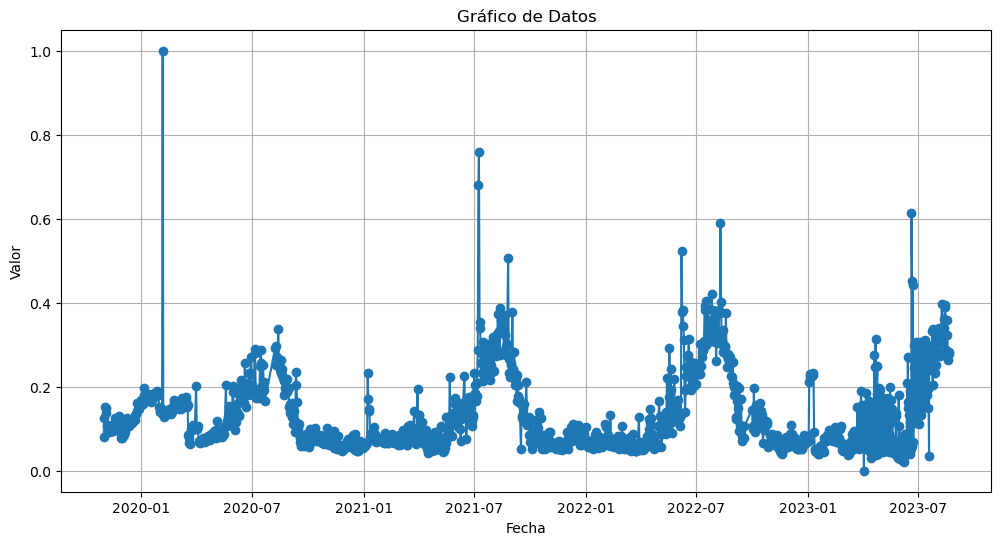

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(df_datos['Fecha'], df_datos['Valor'], marker='o', linestyle='-')
plt.title('Gráfico de Datos')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

In [17]:
# Función para crear secuencias de datos
def crear_secuencias(data, pasos):
    secuencias_x, secuencias_y = [], []
    for i in range(len(data) - pasos):
        secuencias_x.append(data[i:i+pasos])
        secuencias_y.append(data[i+pasos])
    return np.array(secuencias_x), np.array(secuencias_y)

# Definir el número de pasos de tiempo (cuántos valores pasados se usarán para predecir el futuro)
num_pasos = 10
X, y = crear_secuencias(df_datos['Valor'].values, num_pasos)

# Dividir los datos en conjuntos de entrenamiento y prueba
porcentaje_entrenamiento = 0.8
indice_entrenamiento = int(porcentaje_entrenamiento * len(X))

X_entrenamiento, X_prueba = X[:indice_entrenamiento], X[indice_entrenamiento:]
y_entrenamiento, y_prueba = y[:indice_entrenamiento], y[indice_entrenamiento:]

# Reformatear los datos para que sean 3D (número de muestras, pasos de tiempo, número de características)
X_entrenamiento = X_entrenamiento.reshape(-1, num_pasos, 1)
X_prueba = X_prueba.reshape(-1, num_pasos, 1)

In [18]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(num_pasos, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_entrenamiento, y_entrenamiento, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
36/36 [==============================] - 1s 3ms/step - loss: 0.0087
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 8/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 9/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 10/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 11/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 12/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 13/100
36/36 [=================

In [19]:
# Evaluar el modelo en los datos de prueba
loss = model.evaluate(X_prueba, y_prueba)
print(f'Pérdida en datos de prueba: {loss}')

# Realizar predicciones
predicciones = model.predict(X_prueba)

# Invertir la normalización en las predicciones
predicciones_originales = scaler.inverse_transform(predicciones)

9/9 [==============================] - 0s 2ms/step - loss: 0.0056
Pérdida en datos de prueba: 0.005558918230235577
9/9 [==============================] - 0s 2ms/step


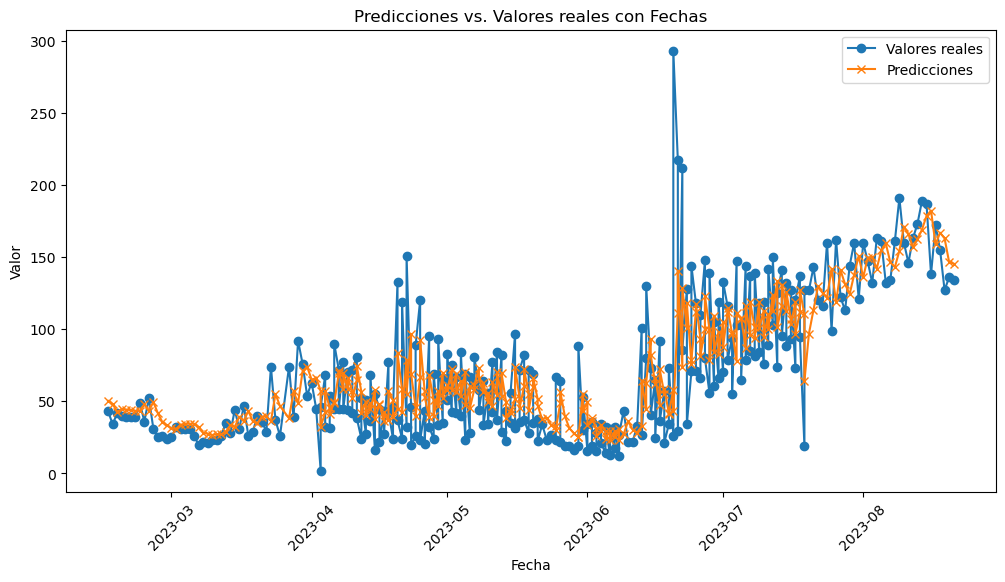

In [20]:
# Invertir la normalización en los valores reales de prueba
y_prueba_originales = scaler.inverse_transform(y_prueba.reshape(-1, 1))

# Obtener las fechas correspondientes a los datos de prueba
fechas_prueba = df_datos['Fecha'].values[-len(y_prueba_originales):]

# Plotear las fechas, valores reales y predicciones
plt.figure(figsize=(12, 6))
plt.plot(fechas_prueba, y_prueba_originales, label='Valores reales', marker='o')
plt.plot(fechas_prueba, predicciones_originales, label='Predicciones', marker='x')
plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones vs. Valores reales con Fechas')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()

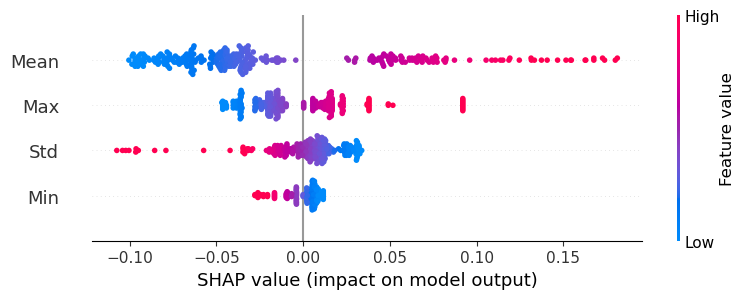

In [21]:
# 1. Extracción de características
def extract_features(data):
    features = []
    for sequence in data:
        # Aquí, calcula estadísticas relevantes sobre cada secuencia y agrégalas a 'features'
        # Por ejemplo, puedes calcular la media, la desviación estándar, el máximo, el mínimo, etc.
        feature = [np.mean(sequence), np.std(sequence), np.max(sequence), np.min(sequence)]
        features.append(feature)
    return np.array(features)

# Extraer características de tus datos de prueba
X_prueba_features = extract_features(X_prueba)

# 2. Entrenar un modelo de explicación (por ejemplo, regresión lineal)
from sklearn.linear_model import LinearRegression

explainer = LinearRegression()
explainer.fit(X_prueba_features, predicciones)

# Crear un objeto explainer SHAP
shap_explainer = shap.LinearExplainer(explainer, X_prueba_features)

# Calcular SHAP values para una muestra de datos
shap_values = shap_explainer.shap_values(X_prueba_features)

# Visualizar las contribuciones de las características
shap.summary_plot(shap_values, X_prueba_features, feature_names=["Mean", "Std", "Max", "Min"])

In [22]:
# Visualizar un gráfico de fuerza para una muestra específica
shap.initjs()
sample_index = 0  # Índice de la muestra que deseas visualizar
shap.force_plot(shap_explainer.expected_value, shap_values[sample_index], X_prueba_features[sample_index], feature_names=["Mean", "Std", "Max", "Min"])

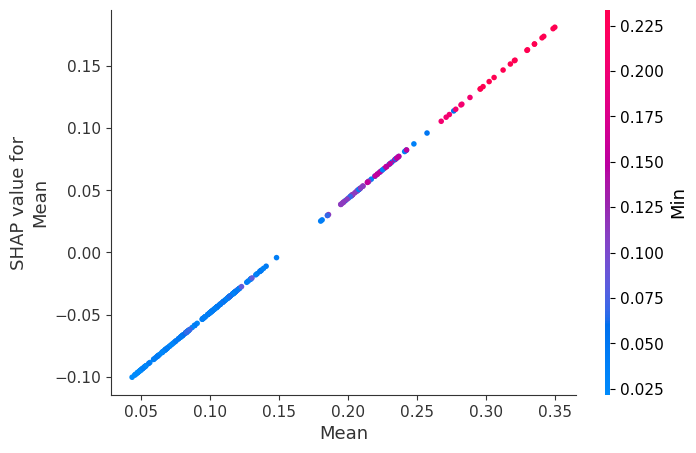

In [23]:
# Visualizar un gráfico de dependencia para una característica específica
feature_index = 0  # Índice de la característica que deseas visualizar
shap.dependence_plot(feature_index, shap_values, X_prueba_features, feature_names=["Mean", "Std", "Max", "Min"])